<a href="https://colab.research.google.com/github/esgantivar/qmc/blob/torch/examples/torch/dmkdc-mps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install qmc if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install git+https://github.com/esgantivar/qmc.git@torch -q
else:
    import sys
    sys.path.insert(0, '../../')

In [3]:
from qmc.torch.utils import get_moons
import torch.nn.functional as F

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
import torch
import torch.nn as nn
import numpy as np
import tensornetwork as tn
from torchvision import datasets, transforms
import torch.utils.data as Data
from torch import optim
from tqdm import tqdm

In [6]:
tn.set_default_backend('pytorch')
torch.cuda.set_device(0) if torch.cuda.is_available() else None

In [146]:
%matplotlib inline
import numpy as np
import pylab as pl

# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    X = X.numpy()
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    CS = pl.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    pl.clabel(CS, inline=1, fontsize=10)
    pl.xlabel("x")
    pl.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        _x = torch.tensor(X, dtype=torch.float)
        xcos = torch.cos((np.pi/2) * _x)
        xsin = torch.sin((np.pi/2) * _x)
        return (clf(torch.stack([xcos, xsin], dim=-1))).detach().numpy()[:, 1]
    return pred_fun

In [7]:
(X, y), (x_train, y_train), (x_test, y_test) = get_moons()

In [8]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.nn.functional.one_hot(torch.tensor(y_train)).to(torch.float)
y_test =  torch.nn.functional.one_hot(torch.tensor(y_test)).to(torch.float)

In [59]:
def simple_side_tensor(bond_dim, phys_dim, std=1e-3):
  ans = torch.zeros(phys_dim, bond_dim)
  ans[:, 0] = 1.0
  ans = ans.transpose(0, 1)
  return ans + torch.randn_like(ans) * std


def simple_middle_tensor(bond_dim, phys_dim, std=1e-3):
  ans = torch.stack([torch.eye(bond_dim)]*phys_dim, dim=0).transpose(0, 1)
  return ans + torch.randn_like(ans) * std


def simple_mps(nodes, bond_dim, phys_dim, std=1e-3):
	assert nodes>=2
	assert len(phys_dim)==nodes

	ans = []
	ans.append(simple_side_tensor(bond_dim, phys_dim[0], std))

	for i in range(1, nodes-1):
		ans.append(simple_middle_tensor(bond_dim, phys_dim[i], std))

	ans.append(simple_side_tensor(bond_dim, phys_dim[-1], std))
	return ans

In [70]:
class QMeasureDensityMPS(nn.Module):
  def __init__(self, n_sites, bond_dim, phys_dim):
    super(QMeasureDensityMPS, self).__init__()

    self.n_sites = n_sites
    self.bond_dim = bond_dim
    self.phys_dim = phys_dim

    mps = simple_mps(
        nodes=n_sites,
        bond_dim=bond_dim,
        phys_dim=[phys_dim] * n_sites,
        std=1e-3
    )

    self.mps_var = [nn.Parameter(i, requires_grad=True) for i in mps]

    for i, v in enumerate(self.mps_var):
        self.register_parameter(f'mps{i}', param=v)

  def forward(self, inputs):
    def f(input_vec, mps_var):
      mps_nodes = []
      input_nodes = []

      for i in mps_var:
          mps_nodes.append(tn.Node(i))
      for i in range(input_vec.shape[0]):
          input_nodes.append(tn.Node(input_vec[i]))
      
      mps_nodes[0][0] ^ mps_nodes[1][0]
      for i in range(1, self.n_sites - 1):
          mps_nodes[i][2] ^ mps_nodes[i+1][0]
      
      for i in range(self.n_sites):
          mps_nodes[i][1] ^ input_nodes[i][0]
      
      # Contract
      for i in range(self.n_sites):
          mps_nodes[i] = mps_nodes[i] @ input_nodes[i]
      
      ans = mps_nodes[0]
      for i in range(1, self.n_sites):
          ans = ans @ mps_nodes[i]
      
      return ans.tensor
    ans = torch.stack([f(vec, self.mps_var) for vec in inputs], dim=0)
    return ans

In [93]:
class DMKDClassifierSGD(torch.nn.Module):
  def __init__(self, n_sites, bond_dim, phys_dim, num_classes):
    super(DMKDClassifierSGD, self).__init__()

    self.n_sites = n_sites
    self.bond_dim = bond_dim
    self.phys_dim = phys_dim
    self.num_classes = num_classes

    self.qmd = []
    for _ in range(num_classes):
      qml = QMeasureDensityMPS(n_sites, bond_dim, phys_dim)
      self.add_module(f'qmps_{_}', qml)
      self.qmd.append(qml)

  def forward(self, inputs):
    probs = []
    for i in range(self.num_classes):
      probs.append(self.qmd[i](inputs))
    posteriors = torch.stack(probs, dim=-1)
    posteriors = (posteriors / torch.unsqueeze(torch.sum(posteriors, dim=-1), dim=-1))
    return F.softmax(posteriors, dim=1)

In [148]:
model = DMKDClassifierSGD(n_sites=2, bond_dim=32, phys_dim=2, num_classes=2)

In [149]:
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.BCELoss()

In [150]:
for _ in range(20):
    correct = 0
    xcos = torch.cos((np.pi/2) * x_train)
    xsin = torch.sin((np.pi/2) * x_train)
    batchx = torch.stack([xcos, xsin], dim=-1)
    y_pred = model(batchx)
    loss = loss_func(y_pred, y_train)
    optimizer.zero_grad()
    for i in range(len(y_pred)):
        if torch.argmax(y_pred[i]) == torch.argmax(y_train[i]):
            correct += 1
    print(correct/len(y_pred))
    loss.backward()
    optimizer.step()

0.13059701492537312
0.8417910447761194
0.8432835820895522
0.8440298507462687
0.8455223880597015
0.8477611940298507
0.8485074626865672
0.8507462686567164
0.8507462686567164
0.8514925373134329
0.8522388059701492
0.8537313432835821
0.8537313432835821
0.8552238805970149
0.8559701492537314
0.8582089552238806
0.858955223880597
0.8582089552238806
0.8604477611940299
0.8604477611940299


In [151]:
xcos = torch.cos((np.pi/2) * x_test)
xsin = torch.sin((np.pi/2) * x_test)
batchx = torch.stack([xcos, xsin], dim=-1)

In [152]:
out = model(batchx)
out[:10]

tensor([[0.4658, 0.5342],
        [0.5182, 0.4818],
        [0.4818, 0.5182],
        [0.4519, 0.5481],
        [0.4807, 0.5193],
        [0.5484, 0.4516],
        [0.5070, 0.4930],
        [0.4570, 0.5430],
        [0.5344, 0.4656],
        [0.4596, 0.5404]], grad_fn=<SliceBackward>)

0.37795162 0.37795162


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


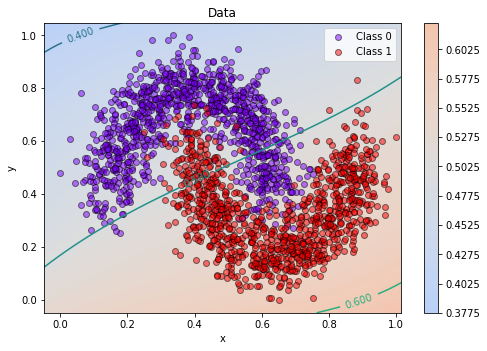

In [153]:
pl.figure(figsize = (8,16/3))    
plot_decision_region(x_test, gen_pred_fun(model))
plot_data(X, y)